In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from einops import rearrange
from einops.layers.torch import Rearrange

from typing import Optional

from dataclasses import dataclass
from simple_parsing.helpers import Serializable
import time
import numpy as np
## Functions


class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.w1 = nn.Linear(config.dim, config.hidden_dim, bias=False)
        self.w2 = nn.Linear(config.hidden_dim, config.dim, bias=False)
        self.w3 = nn.Linear(config.dim, config.hidden_dim, bias=False)

    def forward(self, x) -> torch.Tensor:
        return self.w2(nn.functional.silu(self.w1(x)) * self.w3(x))

class CausalSelfAttention(nn.Module): 
    """
    Simple Multi head attention with einops and F.scaled_dot_product_attention.
    """
    def __init__(self, config, is_causal=True):

        super().__init__()

        assert config.n_heads == config.n_kv_heads, "n_heads should be equal n_kv_heads"

        self.n_heads = config.n_heads
        self.n_kv_heads = config.n_heads # for simplicity we use vanilla transformer.
        self.repeats = self.n_heads // self.n_kv_heads
        self.head_dim = config.head_dim

        self.qw = nn.Linear(config.dim, config.head_dim * config.n_heads, bias=False)
        self.kw = nn.Linear(config.dim, config.head_dim * config.n_kv_heads, bias=False)
        self.vw = nn.Linear(config.dim, config.head_dim * config.n_kv_heads, bias=False)

        self.project = nn.Linear(config.head_dim * config.n_heads, config.dim, bias=False)

    def forward(self, x, attn_mask):
        B, T, C = x.size() # b, t, c*h        
        q, k, v = self.qw(x), self.kw(x), self.vw(x) 

        # split by n_heads.
        q = rearrange(q, 'b t (nh c) -> b t nh c', b=B, t=T, nh=self.n_heads, c=self.head_dim)
        k = rearrange(k, 'b t (nh c) -> b t nh c', b=B, t=T, nh=self.n_heads, c=self.head_dim)
        v = rearrange(v, 'b t (nh c) -> b t nh c', b=B, t=T, nh=self.n_heads, c=self.head_dim)


        if attn_mask is not None:
            t_q, t_k = q.size(1), k.size(1)
            attn_mask = attn_mask[..., :t_q, :t_k]

        q = q.transpose(1, 2)  # (B, nh, T, c)
        k = k.transpose(1, 2)  # (B, nh, T, c)
        v = v.transpose(1, 2)  # (B, nh, T, c)
        
        res = F.scaled_dot_product_attention(q, k, v, attn_mask=attn_mask)  

        res = rearrange(res, 'b nh t c -> b t (nh c)', b=B, t=T, nh=self.n_heads, c=self.head_dim)
        res = self.project(res)

        return res

class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = RMSNorm(config.dim)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = RMSNorm(config.dim)
        self.mlp = MLP(config)

    def forward(self, x, attn_mask=None):
        x = x + self.attn(self.ln_1(x), attn_mask) 
        x = x + self.mlp(self.ln_2(x))
        return x

class SimpleEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            emb = nn.Linear(config.patch_size, config.dim),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layers)]),
            ln_f = nn.LayerNorm(config.dim),
        ))
        num_patches = config.block_size
        self.n_registers = config.n_registers
        self.registers = nn.Parameter(torch.zeros(1, self.n_registers, config.dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + self.n_registers, config.dim))

        self.attn_mask = torch.ones(config.block_size+self.n_registers, config.block_size+self.n_registers).to(torch.bool)
        
        print(config)
        print("Encoder: number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_attn_mask_padded(self, x):
        is_padded = (x == 0).all(dim=2)
        # is_padded = torch.ones(self.n_registers)is_padded
        attn_mask = ~is_padded.unsqueeze(1).repeat(1, x.size(1), 1)
        attn_mask = F.pad(attn_mask, (self.n_registers, 0, self.n_registers, 0), 'constant', value=True)
        return attn_mask
        
    def forward(self, x, attn_mask=None):
        """
        myo signals with shape: with shape [B, T, C]
        """
        attn_mask = self.attn_mask if attn_mask is None else attn_mask
        attn_mask = attn_mask.to(self.device)

        

        b, t, c = x.shape
        x = self.transformer.emb(x)
        
        registers = self.registers.expand(b, -1, -1)
        x = torch.cat([registers, x], axis=1)
        
        x = x + self.pos_embedding

        for block in self.transformer.h:
            x = block(x, attn_mask=attn_mask)

        x = self.transformer.ln_f(x)
        return x 


    @property
    def dtype(self) -> torch.dtype:
        return next(self.parameters()).dtype

    @property
    def device(self) -> torch.device:
        return next(self.parameters()).device

    @property
    def rope_cache(self) -> torch.Tensor:
        # Just to use proper device.
        if self.precompute_rope_cash.device != self.device:
            self.precompute_rope_cash = self.precompute_rope_cash.to(device=self.device)
        return self.precompute_rope_cash
    
    def get_num_params(self):
        n_params = sum(p.numel() for p in self.parameters())
        return n_params



class SimpleMAE(nn.Module):
    def __init__(self, encoder_config, mae_config):
        super().__init__()
        self.encoder_config = encoder_config
        
        self.encoder = SimpleEncoder(encoder_config)
        self.dim = mae_config.dim

        self.decoder = nn.ModuleDict(dict(
            emb = nn.Linear(encoder_config.dim, mae_config.dim), # connection between them.
            h = nn.ModuleList([Block(mae_config) for _ in range(mae_config.n_layers)]),
        ))

        self.mask_token = nn.Parameter(torch.randn(mae_config.dim))
        self.decoder_pos_emb = nn.Parameter(torch.randn(1, encoder_config.block_size + encoder_config.n_registers, mae_config.dim))
        self.to_signals = nn.Linear(mae_config.dim, encoder_config.patch_size)

        print("MAE: number of parameters: %.2fM" % (self.get_num_params()/1e6))

    def get_num_params(self, non_embedding=True):
        n_params = sum(p.numel() for p in self.parameters())
        return n_params

    def get_masking_indices(self, masking_ratio, x):
        b, n_tokens, _ = x.shape

        num_masked = int(masking_ratio * n_tokens)
        rand_indices = torch.rand(b, n_tokens, device = x.device).argsort(dim=-1) # get idxs of random values.
        masked_indices, unmasked_indices = rand_indices[:, :num_masked], rand_indices[:, num_masked:]

        masked_indices, _ = torch.sort(masked_indices, dim=1)
        unmasked_indices, _ = torch.sort(unmasked_indices, dim=1)      
        
        return masked_indices, unmasked_indices
    

    def forward(self, x, targets=None, date_info=None, masking_ratio=0.75, return_preds=False):
        """
        Inputs: x with shape -> B, T, C
        """
        b, t, c = x.shape

        # Attention mask for padded tokens.
        registers = self.encoder.registers.expand(b, -1, -1)
        n_registers = registers.size(1)
        
        is_padded = (x == 0).all(dim=2)
        attn_mask = ~is_padded.unsqueeze(1).repeat(1, x.size(1), 1)
        
        # Masking
        masked_indices, unmasked_indices = self.get_masking_indices(masking_ratio, x) # [b, N]
        batch_range = torch.arange(b, device=x.device)[:, None]

        attn_mask_unmasked = attn_mask[batch_range[..., None], unmasked_indices[..., None], unmasked_indices[:, None, :]]
        attn_mask_unmasked = F.pad(attn_mask_unmasked, (n_registers, 0, n_registers, 0), 'constant', value=True)
        attn_mask_unmasked = rearrange(attn_mask_unmasked, 'b h w -> b 1 h w')
        
        # Encoder
        registers = registers + self.encoder.pos_embedding[:, :n_registers]
        
        tokens = self.encoder.transformer.emb(x)
        tokens = tokens + self.encoder.pos_embedding[:, n_registers:n_registers+t,:]
        tokens = tokens[batch_range, unmasked_indices]
        
        tokens = torch.cat([registers, tokens], axis=1)

        for block in self.encoder.transformer.h:
            tokens = block(tokens, attn_mask_unmasked)
        
        ### DECODER 
        attn_mask = rearrange(attn_mask, 'b h w -> b 1 h w') # include registers. 

        unmasked_decoder_tokens = self.decoder.emb(tokens)

        decoder_tokens = torch.zeros(b, t, self.dim, device=x.device, dtype=x.dtype)
        decoder_tokens[batch_range, unmasked_indices] = unmasked_decoder_tokens[:, n_registers:]
        decoder_tokens[batch_range, masked_indices] = self.mask_token

        decoder_tokens = torch.cat([unmasked_decoder_tokens[:, :n_registers], decoder_tokens], axis=1)
        decoder_tokens = decoder_tokens + self.decoder_pos_emb[:, :n_registers+t]

        attn_mask = F.pad(attn_mask, (n_registers, 0, n_registers, 0), 'constant', value=True)

        for block in self.decoder.h:
            decoder_tokens = block(decoder_tokens, attn_mask)
        
        decoder_tokens = decoder_tokens[:, n_registers:]
        
        pred_tokens = self.to_signals(decoder_tokens)

        ### LOSS: mse on masked and not padded tokens.
        tokens_pred_masked = pred_tokens[batch_range, masked_indices]
        tokens_real_masked = x[batch_range, masked_indices]

        # let's calculate loss on masked and not padded tokens.
        mask_valid = ~is_padded[batch_range, masked_indices]
        loss_tensor = F.mse_loss(tokens_pred_masked, tokens_real_masked, reduction='none')
        
        loss_real_values = loss_tensor[mask_valid.nonzero(as_tuple=True)]
        recon_loss = torch.mean(loss_real_values)
            
        if return_preds:
            binary_mask = torch.zeros_like(x, device=x.device, dtype=x.dtype) 
            binary_mask[batch_range, masked_indices] = 1

            reconstruction_signal = torch.zeros_like(x, device=x.device, dtype=x.dtype)
            reconstruction_signal[batch_range, masked_indices] = tokens_pred_masked
            reconstruction_signal[batch_range, unmasked_indices] = x[batch_range, unmasked_indices]

            return recon_loss, reconstruction_signal, binary_mask

        return recon_loss, None




In [2]:
@dataclass
class SimpleEncoderConfig(Serializable):
    # data params
    block_size: int = 768
    patch_size: int = 256

    n_layers: int = 8
    dim: int = 256
    hidden_dim: int = 1024
    n_registers: int = 4

    head_dim: int = 32
    n_heads: int = 16
    n_kv_heads: int = 16 # now it should be the same with n_heads.
    rope_theta: int = 10000


@dataclass
class SimpleMAEConfig(Serializable):
    # data params
    n_layers: int = 4
    dim: int = 256
    hidden_dim: int = 1024

    head_dim: int = 32
    n_heads: int = 8
    n_kv_heads: int = 8 # now it should be the same with n_heads.
    rope_theta: int = 10000


In [3]:
cfg=SimpleEncoderConfig()
model = SimpleEncoder(cfg)
model = SimpleMAE(SimpleEncoderConfig(), SimpleMAEConfig())

SimpleEncoderConfig(block_size=768, patch_size=256, n_layers=8, dim=256, hidden_dim=1024, n_registers=4, head_dim=32, n_heads=16, n_kv_heads=16, rope_theta=10000)
Encoder: number of parameters: 10.75M
SimpleEncoderConfig(block_size=768, patch_size=256, n_layers=8, dim=256, hidden_dim=1024, n_registers=4, head_dim=32, n_heads=16, n_kv_heads=16, rope_theta=10000)
Encoder: number of parameters: 10.75M
MAE: number of parameters: 15.28M


In [4]:
x = torch.randn(15, 500, 256)
y = model(x, masking_ratio=0.25)
y

(tensor(1.6761, grad_fn=<MeanBackward0>), None)

In [5]:
import matplotlib.pyplot as plt

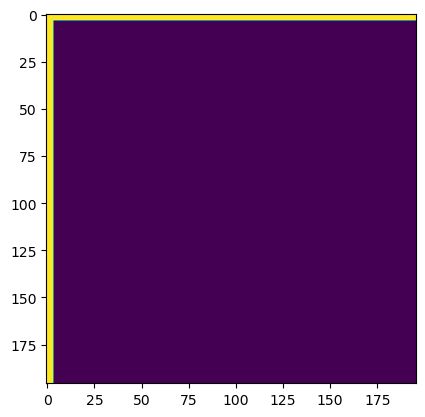

In [6]:
m = torch.zeros(15, 192, 192).to(torch.bool)
res = F.pad(m, (4,0, 4,0), 'constant', value=True)
plt.imshow(res[0])

In [7]:
# import torch
# import torch.nn.functional as F
# import time

# class MaskCreator:
#     def __init__(self, n_registers):
#         self.n_registers = n_registers

#     def get_attn_mask_padded(self, x):
#         seq_len = x.size(1)
#         is_padded = (x == 0).all(dim=2)
#         attn_mask = ~is_padded  # Negate first

#         # Create an initial mask with registers considered not padded
#         full_mask = torch.ones((b, seq_len + self.n_registers, seq_len + self.n_registers), dtype=torch.bool)

#         # Set the non-register parts
#         full_mask[:, self.n_registers:, self.n_registers:] = attn_mask.unsqueeze(1).expand(-1, seq_len, -1)

#         return full_mask

# # Set dimensions and parameters
# n_registers = 10
# b, n_tokens, dim = 128, 512, 64  # Example dimensions for a large batch with sequence length
# x = torch.randn(b, n_tokens, dim)
# x[:, 400:] = 0  # Introducing some padding

# # Create an instance of the class
# mask_creator = MaskCreator(n_registers=n_registers)

# # Time the function
# start_time = time.time()
# mask = mask_creator.get_attn_mask_padded(x)
# elapsed_time = time.time() - start_time
# elapsed_time
